# Time-frequency analysis of grand LFP mean

Here, we take the mean across all (normalized) channels across all subjects of the peri-event LFP response.

In [1]:
import numpy as np
import pandas as pd
import physutils as phys
import physutils.bootstrap as boot
import physutils.tf as tf
import matplotlib.pyplot as plt
import dbio

%matplotlib inline
np.random.seed(12345)

In [2]:
def load_and_preprocess(dtup):
    """
    Load and preprocess LFP data.
    """
    # load data
    lfp = dbio.fetch_all_such_LFP(dbname, *dtup)

    # censor and robustly zscore
    lfpmz = lfp.censor().rzscore()
    
    # mark rows with missing data for later removal
    nanrows = np.any(np.isnan(lfpmz), axis=1)
    
    # take the mean of data across channels
    lfpm = lfpmz.mean(axis=1)
    lfpm[nanrows] = np.nan
    lfpm = phys.LFPset(lfpm)
    
    return lfpm

In [3]:
# data location
dbname = 'data/bart.hdf5'

# get list of (patient, dataset) tuples to plot
dsets = pd.read_csv('data/lfp_channel_file.csv', header=None).iloc[:, :2].drop_duplicates()

In [4]:
offset_time = 0.0
offset_trial = 0
lfp_list = []
stop_list = []
pop_list = []
start_list = []
stops_free_list = []
stops_control_list = []

# for this, use only multichannel datasets where we have a good
# estimate of mean LFP
# (22, 1) is pathological for this analysis
for dtup in [(17, 2), (18, 1), (20, 1), (22, 1), (23, 1), (30, 1)]:
    print dtup

    lfp = load_and_preprocess(dtup)

    # get events
    evt = dbio.fetch(dbname, 'events', *dtup)
    stops = evt['banked'].dropna()
    pops = evt['popped'].dropna()
    starts = evt['start inflating']
    if 'is_control' in evt.columns:
        stops_free = evt.query('is_control == False')['banked'].dropna()
        stops_control = evt.query('is_control == True')['banked'].dropna()
        stops_rewarded = evt.query('trial_type != 4')['banked'].dropna()
        #stops_unrewarded = evt.query('trial_type == 4')['banked'].dropna()
    else:
        stops_free = stops
        stops_control = None
        stops_rewarded = stops
        #stops_unrewarded = None

    # now adjust data so that times and trial numbers are unique
    lfp.index += offset_time
    
    stops += offset_time
    stops.index += offset_trial
    
    pops += offset_time
    pops.index += offset_trial
    
    starts += offset_time
    starts.index += offset_trial
    
    stops_free += offset_time
    stops_free.index += offset_trial
    
    if stops_control is not None:
        stops_control += offset_time
        stops_control.index += offset_trial
    
    
    # get new offsets
    offset_time = lfp.index[-1]
    offset_trial = max(stops.index[-1], pops.index[-1])
    
    # append
    lfp_list.append(lfp.dataframe)
    stop_list.append(stops)
    pop_list.append(pops)
    start_list.append(starts)
    stops_free_list.append(stops_free)
    if stops_control is not None:
        stops_control_list.append(stops_control)
    

(17, 2)
(18, 1)
(20, 1)
(22, 1)
(23, 1)
(30, 1)


In [5]:
# smoosh everything together 
lfp = phys.LFPset(pd.concat(lfp_list))
stops = pd.concat(stop_list)
pops = pd.concat(pop_list)
starts = pd.concat(start_list)
stops_free = pd.concat(stops_free_list)
stops_control = pd.concat(stops_control_list)

In [6]:
Tpre = -2.5
Tpost = 1.5
freqs = np.exp(np.linspace(np.log(2.5), np.log(50)))

# Contrast stops - pops

CPU times: user 5min 24s, sys: 17.2 s, total: 5min 41s
Wall time: 5min 41s


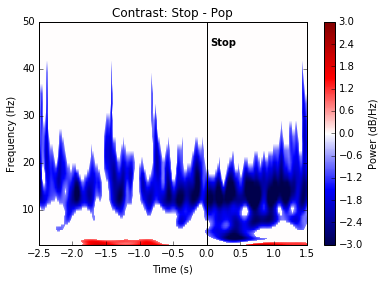

In [ ]:
%%time
thresh = (0.10, 0.9)
mcontr, fig = lfp.significant_time_frequency(0, [stops, pops], 
                                             Tpre, Tpost, thresh=thresh, 
                                             freqs=freqs,
                                             niter=100, method='wav', 
                                             doplot=True, rasterized=True, cmap='seismic', clim=(-3, 3))
# decorations
plt.axvline(x=0, color='k')
plt.text(0.05, 45, 'Stop', fontweight='bold')

plt.title('Contrast: Stop - Pop')

plt.tick_params(axis='x', which='both', top='off');

# Control for motor movement

Free stops and starts contain the same joystick response.

In [ ]:
%%time
mcontr, fig = lfp.significant_time_frequency(0, [stops_free, starts], 
                                             Tpre, Tpost, thresh=(0.025, 0.975), 
                                             freqs=freqs,
                                             niter=100, method='wav', 
                                             doplot=True, clim=(-3, 3), rasterized=True, cmap='seismic')
# decorations
plt.axvline(x=0, color='k')
plt.text(-0.65, 45, 'Movement', fontweight='bold')

plt.title('Contrast: Stop Movement - Start Movement')

plt.tick_params(axis='x', which='both', top='off');

# Contrast voluntary and involuntary stops

In [ ]:
mcontr, fig = lfpm.significant_time_frequency(0, [stops_free, stops_control], 
                                             Tpre, Tpost, thresh=(0.1, 0.9), 
                                             freqs=freqs,
                                             niter=100, method='wav', 
                                             doplot=True, rasterized=True, cmap='seismic', clim=(-3, 3))
# decorations
plt.axvline(x=0, color='k')
plt.text(0.05, 45, 'Stop', fontweight='bold')

plt.title('Contrast: Free Stop - Forced Stop')

plt.tick_params(axis='x', which='both', top='off');